In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import math
import pandas_datareader as web

In [28]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [29]:
import datetime
import yfinance as yf

# Define start and end dates
start_date = "2007-01-02"
end_date = datetime.date.today().strftime("%Y-%m-%d")  # Convert to string format

# Fetch data using yfinance
data = yf.download('^NSEBANK', start=start_date, end=end_date)
print(data.head())
print(data.columns)
# Select 'Adj Close' column and rename it to 'Price'
data = data[['Close']]
data.columns = ['Price']

print(data.head())  # Display first few rows


[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open   Volume
Ticker         ^NSEBANK     ^NSEBANK     ^NSEBANK     ^NSEBANK ^NSEBANK
Date                                                                   
2007-09-17  6897.020020  6977.119187  6842.920550  6897.919911        0
2007-09-18  7059.567871  7078.867940  6883.520112  6921.069480        0
2007-09-19  7401.764160  7419.263957  7110.917439  7110.917439        0
2007-09-20  7390.063965  7462.813119  7343.514701  7404.864086        0
2007-09-21  7464.413086  7506.262696  7367.064122  7378.213894        0
MultiIndex([( 'Close', '^NSEBANK'),
            (  'High', '^NSEBANK'),
            (   'Low', '^NSEBANK'),
            (  'Open', '^NSEBANK'),
            ('Volume', '^NSEBANK')],
           names=['Price', 'Ticker'])
                  Price
Date                   
2007-09-17  6897.020020
2007-09-18  7059.567871
2007-09-19  7401.764160
2007-09-20  7390.063965
2007-09-21  7464.413086


In [30]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 4004 number of days in the dataset.


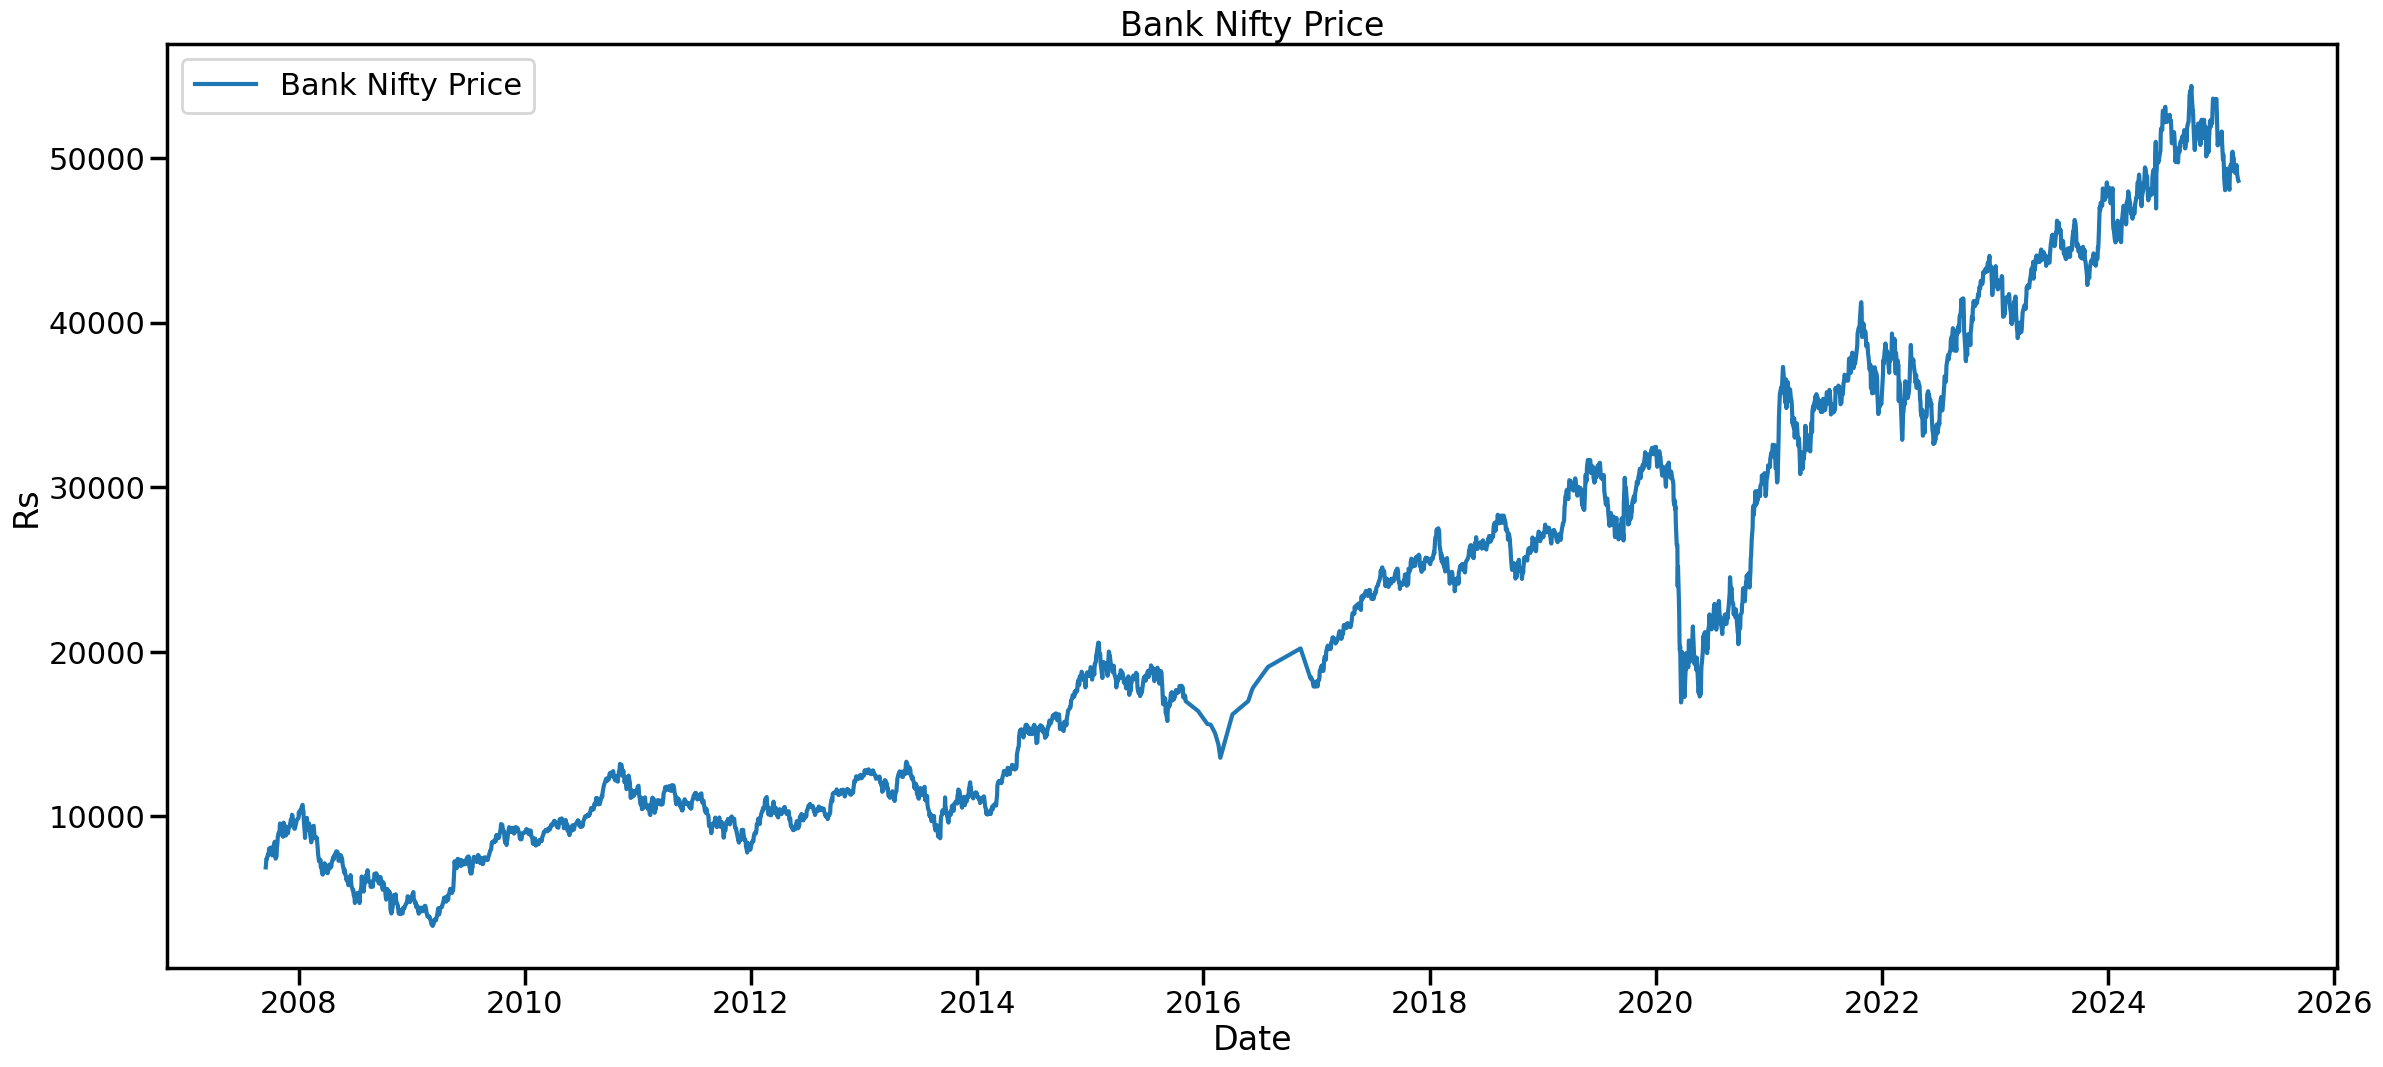

In [31]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['Price'], label='Bank Nifty Price')
plt.xlabel('Date')
plt.ylabel('Rs')
plt.title('Bank Nifty Price')
plt.legend()
plt.show()

In [32]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()

    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['Price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [33]:
df = get_technical_indicators(data)

In [34]:
df = df.dropna()
df.head()

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2007-10-16,8452.101562,8054.791922,7784.471354,7923.731019,8042.612357,118.881339,386.856369,8558.184092,7010.758617,8363.607803,8451.101562,9.042052
2007-10-17,8099.805664,8122.434012,7841.746861,7939.713390,8051.640133,111.926742,334.374992,8510.496844,7172.996878,8187.739710,8098.805664,8.999472
2007-10-18,7608.661621,8081.420201,7867.894182,7910.157159,7981.996045,71.838886,288.470113,8444.834409,7290.953956,7801.687651,7607.661621,8.936911
2007-10-19,7423.713379,7994.728306,7868.939383,7867.378049,7894.519035,27.140986,286.731283,8442.401949,7295.476817,7549.704803,7422.713379,8.912300
2007-10-22,7567.912109,7910.329311,7877.408343,7841.402490,7843.488268,2.085778,274.234037,8425.876416,7328.940269,7561.843007,7566.912109,8.931540


In [35]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

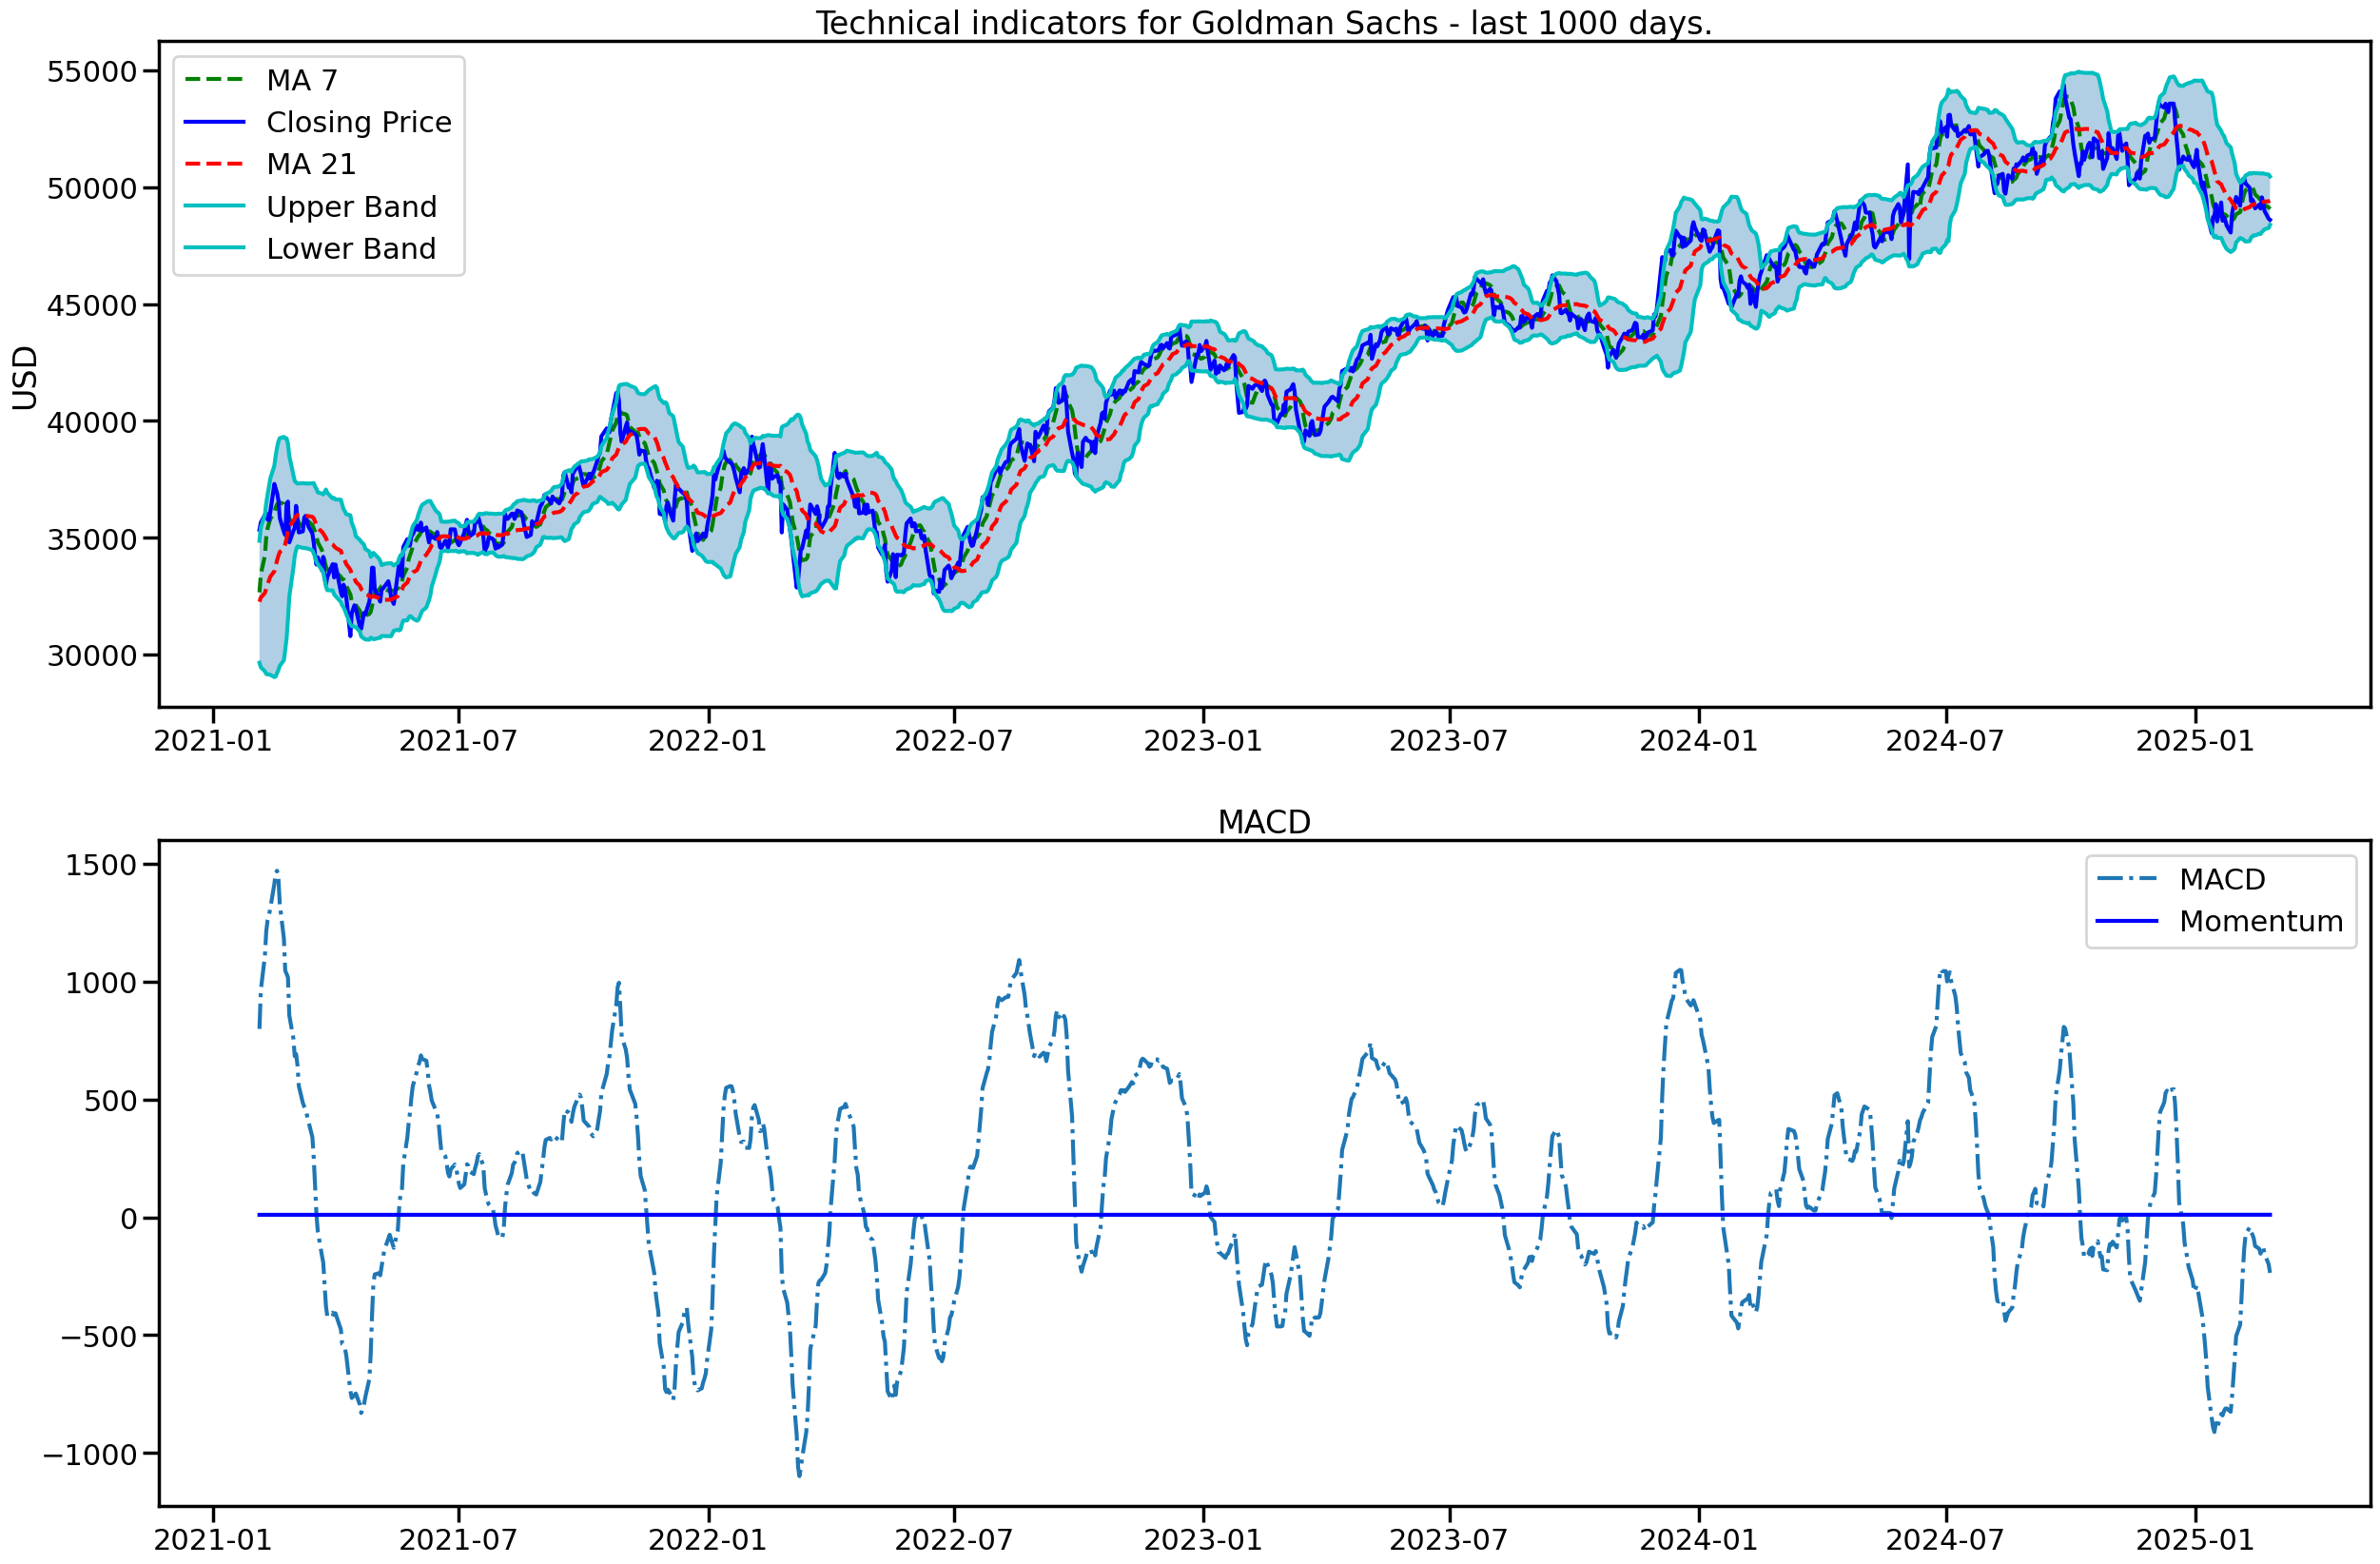

In [36]:
plot_technical_indicators(df, 1000)

Text(0.5, 1.0, 'Params')

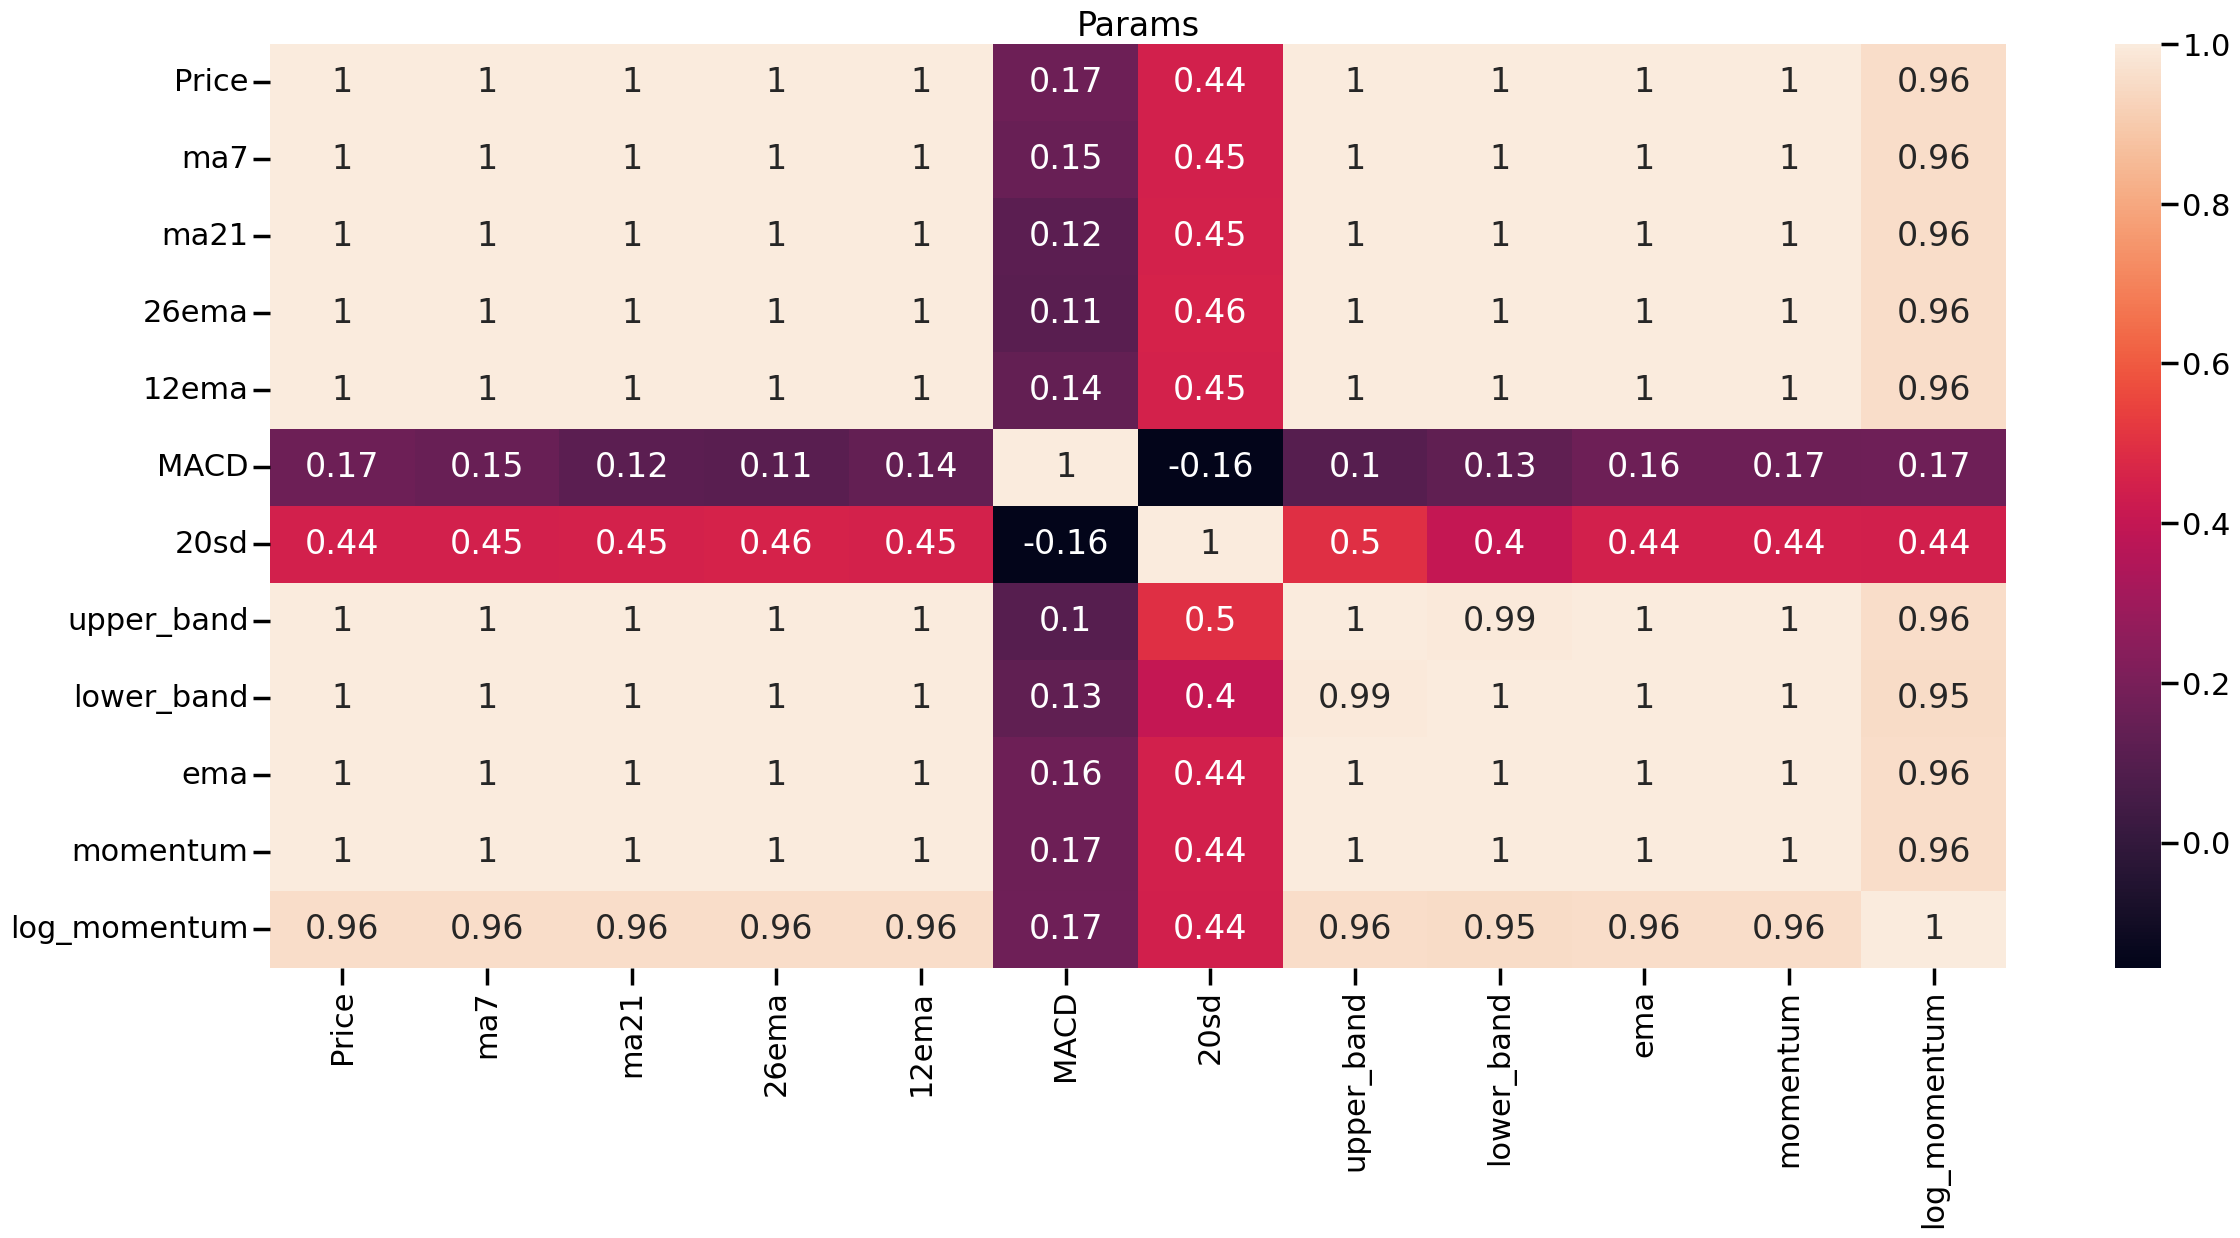

In [37]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')


In [38]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 3984 samples, and 12 features.


In [39]:
df.columns

Index(['Price', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum'],
      dtype='object')

In [40]:
df

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2007-10-16,8452.101562,8054.791922,7784.471354,7923.731019,8042.612357,118.881339,386.856369,8558.184092,7010.758617,8363.607803,8451.101562,9.042052
2007-10-17,8099.805664,8122.434012,7841.746861,7939.713390,8051.640133,111.926742,334.374992,8510.496844,7172.996878,8187.739710,8098.805664,8.999472
2007-10-18,7608.661621,8081.420201,7867.894182,7910.157159,7981.996045,71.838886,288.470113,8444.834409,7290.953956,7801.687651,7607.661621,8.936911
2007-10-19,7423.713379,7994.728306,7868.939383,7867.378049,7894.519035,27.140986,286.731283,8442.401949,7295.476817,7549.704803,7422.713379,8.912300
2007-10-22,7567.912109,7910.329311,7877.408343,7841.402490,7843.488268,2.085778,274.234037,8425.876416,7328.940269,7561.843007,7566.912109,8.931540
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-19,49570.101562,49322.635603,49341.416667,49570.346198,49439.611282,-130.734916,628.293849,50598.004366,48084.828968,49426.230765,49569.101562,10.811123
2025-02-20,49334.550781,49312.800223,49370.471540,49552.879871,49423.448128,-129.431742,612.236514,50594.944567,48145.998513,49365.110776,49333.550781,10.806360
2025-02-21,48981.199219,49241.621652,49389.147693,49510.533156,49355.409834,-155.123321,592.882002,50574.911698,48203.383689,49109.169738,48980.199219,10.799171


In [41]:
data_training = df[df.index < '2019-01-31'].copy()
data_training

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2007-10-16,8452.101562,8054.791922,7784.471354,7923.731019,8042.612357,118.881339,386.856369,8558.184092,7010.758617,8363.607803,8451.101562,9.042052
2007-10-17,8099.805664,8122.434012,7841.746861,7939.713390,8051.640133,111.926742,334.374992,8510.496844,7172.996878,8187.739710,8098.805664,8.999472
2007-10-18,7608.661621,8081.420201,7867.894182,7910.157159,7981.996045,71.838886,288.470113,8444.834409,7290.953956,7801.687651,7607.661621,8.936911
2007-10-19,7423.713379,7994.728306,7868.939383,7867.378049,7894.519035,27.140986,286.731283,8442.401949,7295.476817,7549.704803,7422.713379,8.912300
2007-10-22,7567.912109,7910.329311,7877.408343,7841.402490,7843.488268,2.085778,274.234037,8425.876416,7328.940269,7561.843007,7566.912109,8.931540
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-24,27266.083984,27428.559431,27316.272972,27208.597766,27369.272579,160.674812,220.655927,27757.584826,26874.961119,27287.727213,27265.083984,10.213362
2019-01-25,27114.986328,27375.931920,27322.392020,27201.663586,27330.151617,128.488031,212.691272,27747.774564,26897.009476,27172.566623,27113.986328,10.207805
2019-01-28,26652.740234,27250.833426,27311.654018,27161.002597,27225.934481,64.931885,240.155274,27791.964567,26831.343469,26826.015697,26651.740234,10.190610


In [42]:
data_testing = df[df.index >= '2019-01-31'].copy()
data_testing

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2019-01-31,27295.132812,26996.808036,27275.187872,27110.569379,27112.501377,1.931998,302.590552,27880.368977,26670.006767,27119.841293,27294.132812,10.214427
2019-02-01,27085.634766,26973.265346,27281.192522,27108.722371,27108.368052,-0.354318,297.216979,27875.626480,26686.758564,27097.036941,27084.634766,10.206722
2019-02-04,27186.283203,26961.865234,27280.792504,27114.467617,27120.354998,5.887381,297.344857,27875.482217,26686.102790,27156.534449,27185.283203,10.210431
2019-02-05,27271.382812,26984.207589,27279.228144,27126.090965,27143.590047,17.499082,297.301775,27873.831693,26684.624594,27233.100025,27270.382812,10.213557
2019-02-06,27402.031250,27091.249163,27274.125837,27146.530986,27183.350232,36.819246,294.059781,27862.245398,26686.006276,27345.720842,27401.031250,10.218336
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-19,49570.101562,49322.635603,49341.416667,49570.346198,49439.611282,-130.734916,628.293849,50598.004366,48084.828968,49426.230765,49569.101562,10.811123
2025-02-20,49334.550781,49312.800223,49370.471540,49552.879871,49423.448128,-129.431742,612.236514,50594.944567,48145.998513,49365.110776,49333.550781,10.806360
2025-02-21,48981.199219,49241.621652,49389.147693,49510.533156,49355.409834,-155.123321,592.882002,50574.911698,48203.383689,49109.169738,48980.199219,10.799171


In [43]:
scalar = MinMaxScaler()

data_training_scaled = scalar.fit_transform(data_training)
print(data_training_scaled.shape)
data_training_scaled

(2493, 12)


array([[0.20466127, 0.1844814 , 0.16702761, ..., 0.2003706 , 0.20466127,
        0.43440039],
       [0.19055816, 0.18722454, 0.16938591, ..., 0.19329456, 0.19055816,
        0.41448403],
       [0.17089668, 0.18556127, 0.17046251, ..., 0.17776178, 0.17089668,
        0.38522202],
       ...,
       [0.93326945, 0.96295368, 0.97105193, ..., 0.94320442, 0.93326945,
        0.97162384],
       [0.93008096, 0.95783643, 0.96996994, ..., 0.93642017, 0.93008096,
        0.97022392],
       [0.94017286, 0.95373418, 0.9693137 , ..., 0.94092079, 0.94017286,
        0.97464054]])

In [74]:
X_train = []
y_train = []

In [75]:
for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])

In [46]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2433, 60, 12), (2433,))

In [47]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 12)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
regressor.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 50)              │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 60, 60)              │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 60, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 60, 80)              │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 60, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 180,961 (706.88 KB)

 Trainable params: 180,961 (706.88 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [62]:
regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - loss: 0.0079
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - loss: 0.0069
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - loss: 0.0079
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 0.0063
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 0.0062
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - loss: 0.0061
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.0055
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.0054
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0063
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 0.0048
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - loss: 0.0061
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - loss: 0.0048
Epoch 13/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 0.0211
Epoch 14/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 0.0067
Epoch 15/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms

In [63]:
past_60 = data_training.tail(60)

dt = pd.concat([past_60, data_testing], ignore_index=True)
dt

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,25701.351562,25026.065848,25021.713728,25326.704352,25142.846290,-183.858062,359.701904,25741.117535,24302.309920,25543.932095,25700.351562,10.154260
1,25731.900391,25156.743025,25065.184617,25356.718874,25233.469998,-123.248875,388.027196,25841.239009,24289.130224,25669.244292,25730.900391,10.155448
2,25597.703125,25324.876674,25120.162574,25374.569559,25289.505864,-85.063695,377.127089,25874.416753,24365.908396,25621.550181,25596.703125,10.150219
3,25737.201172,25435.989955,25173.454892,25401.431160,25358.382065,-43.049095,381.673125,25936.801142,24410.108643,25698.650841,25736.201172,10.155654
4,25770.701172,25573.595703,25232.661365,25428.784494,25421.815774,-6.968720,372.769716,25978.200797,24487.121934,25746.684395,25769.701172,10.156955
...,...,...,...,...,...,...,...,...,...,...,...,...
1546,49570.101562,49322.635603,49341.416667,49570.346198,49439.611282,-130.734916,628.293849,50598.004366,48084.828968,49426.230765,49569.101562,10.811123
1547,49334.550781,49312.800223,49370.471540,49552.879871,49423.448128,-129.431742,612.236514,50594.944567,48145.998513,49365.110776,49333.550781,10.806360
1548,48981.199219,49241.621652,49389.147693,49510.533156,49355.409834,-155.123321,592.882002,50574.911698,48203.383689,49109.169738,48980.199219,10.799171
1549,48651.949219,49140.492746,49402.678571,49446.934346,49247.185124,-199.749221,571.255139,50545.188849,48260.168294,48804.356058,48650.949219,10.792427


In [64]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

(1551, 12)


array([[0.23450057, 0.20193035, 0.18261871, ..., 0.2203139 , 0.23450057,
        0.3581842 ],
       [0.23531612, 0.20554374, 0.18390572, ..., 0.22371552, 0.23531612,
        0.35920162],
       [0.2317335 , 0.21019284, 0.18553341, ..., 0.22242085, 0.2317335 ,
        0.35472317],
       ...,
       [0.85599426, 0.87151999, 0.90404612, ..., 0.85999604, 0.85599426,
        0.91052079],
       [0.84720439, 0.86872365, 0.90444672, ..., 0.85172182, 0.84720439,
        0.90474419],
       [0.84604048, 0.86678373, 0.90521324, ..., 0.84817477, 0.84604048,
        0.90397635]])

In [65]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((1491, 60, 12), (1491,))

In [66]:
y_pred = regressor.predict(X_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [67]:
y_pred

array([[0.241822  ],
       [0.24178131],
       [0.24157098],
       ...,
       [0.8030947 ],
       [0.80338866],
       [0.8035527 ]], dtype=float32)

In [68]:
scale = 1/scalar.scale_[0]

In [69]:
y_pred = y_pred*scale
y_test = y_test*scale

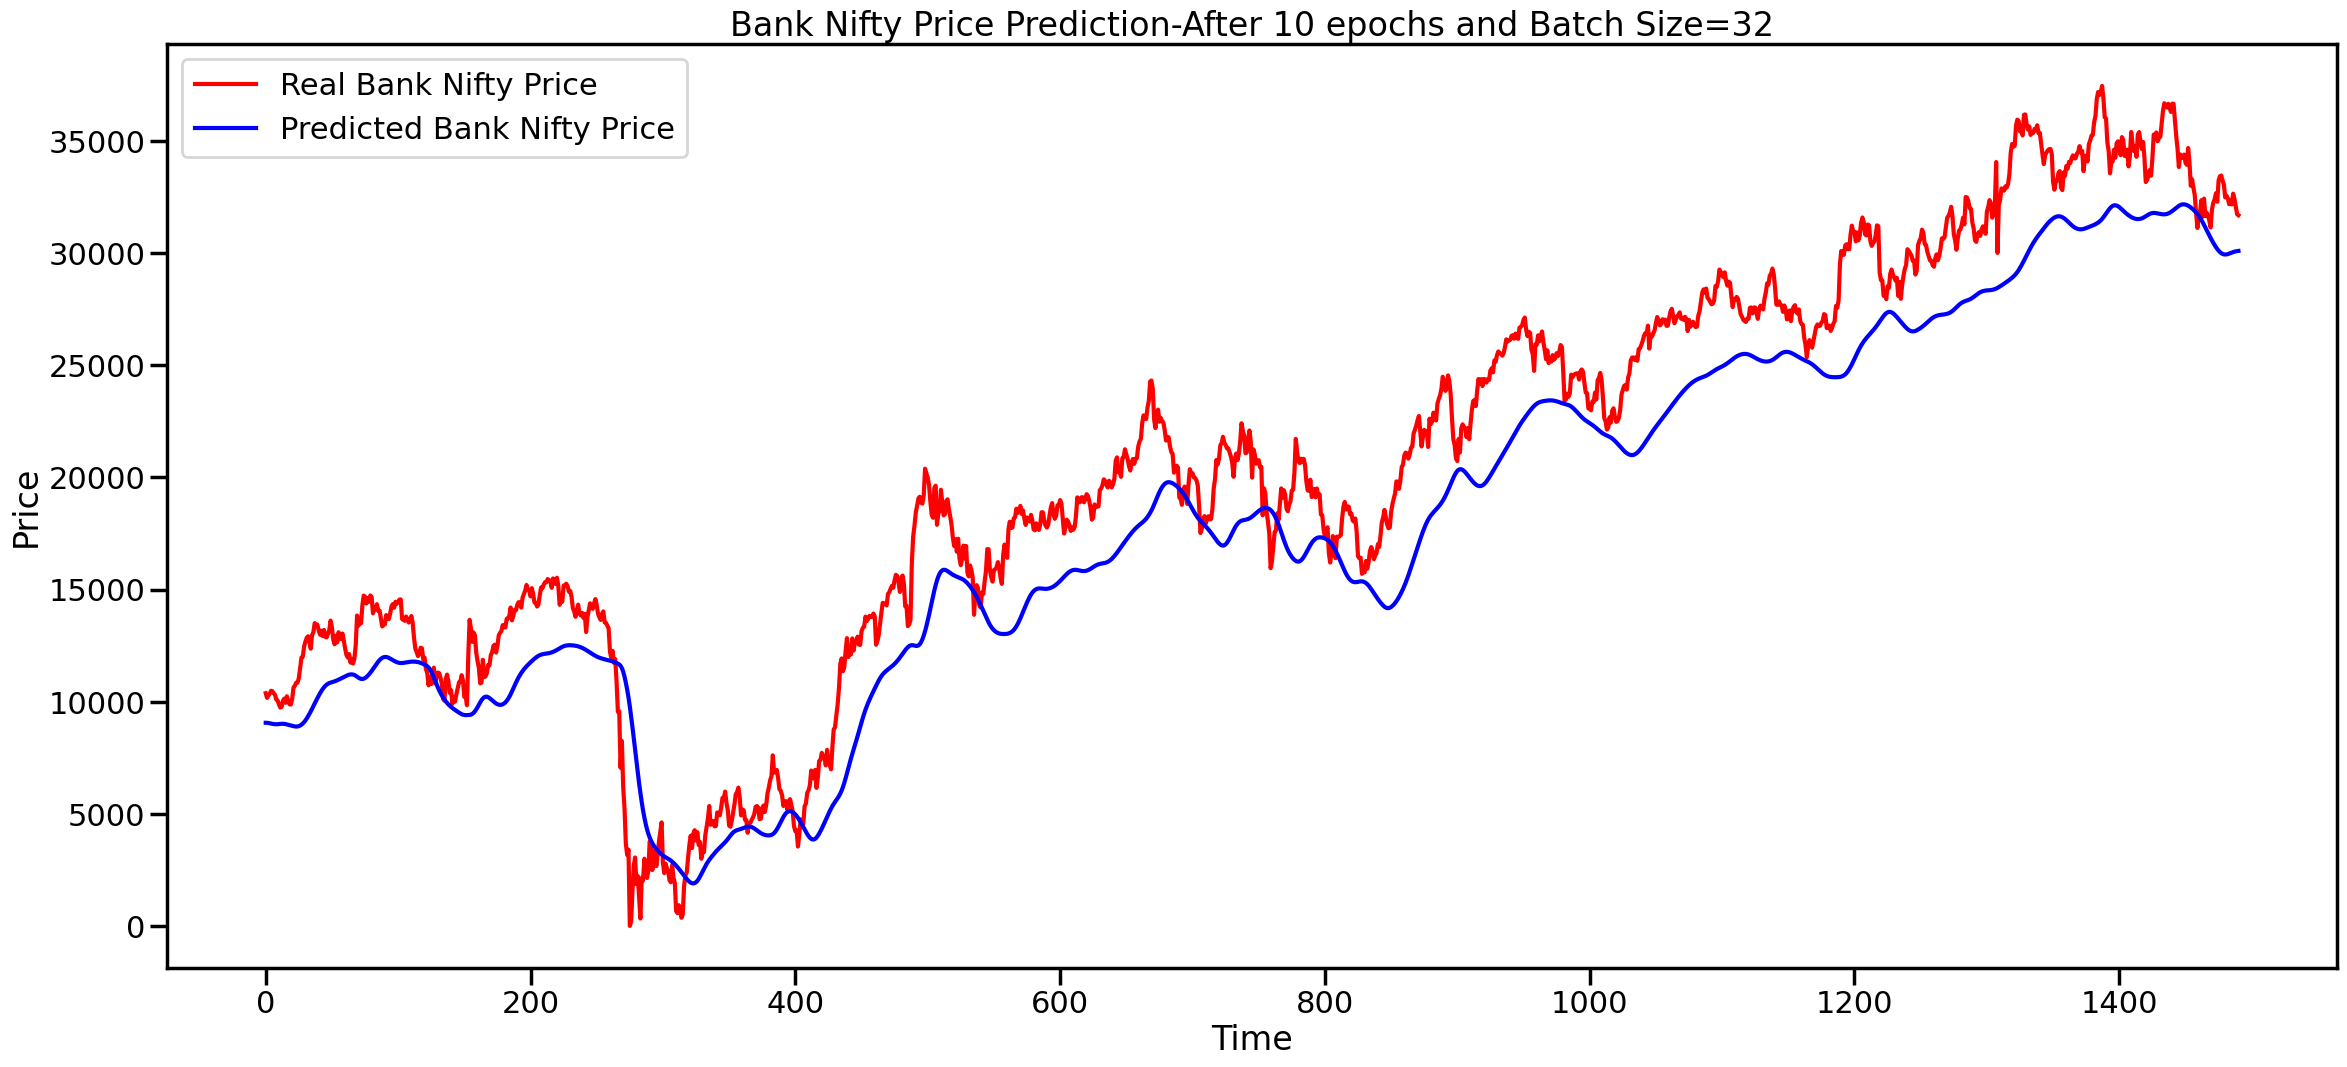

In [70]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 10 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

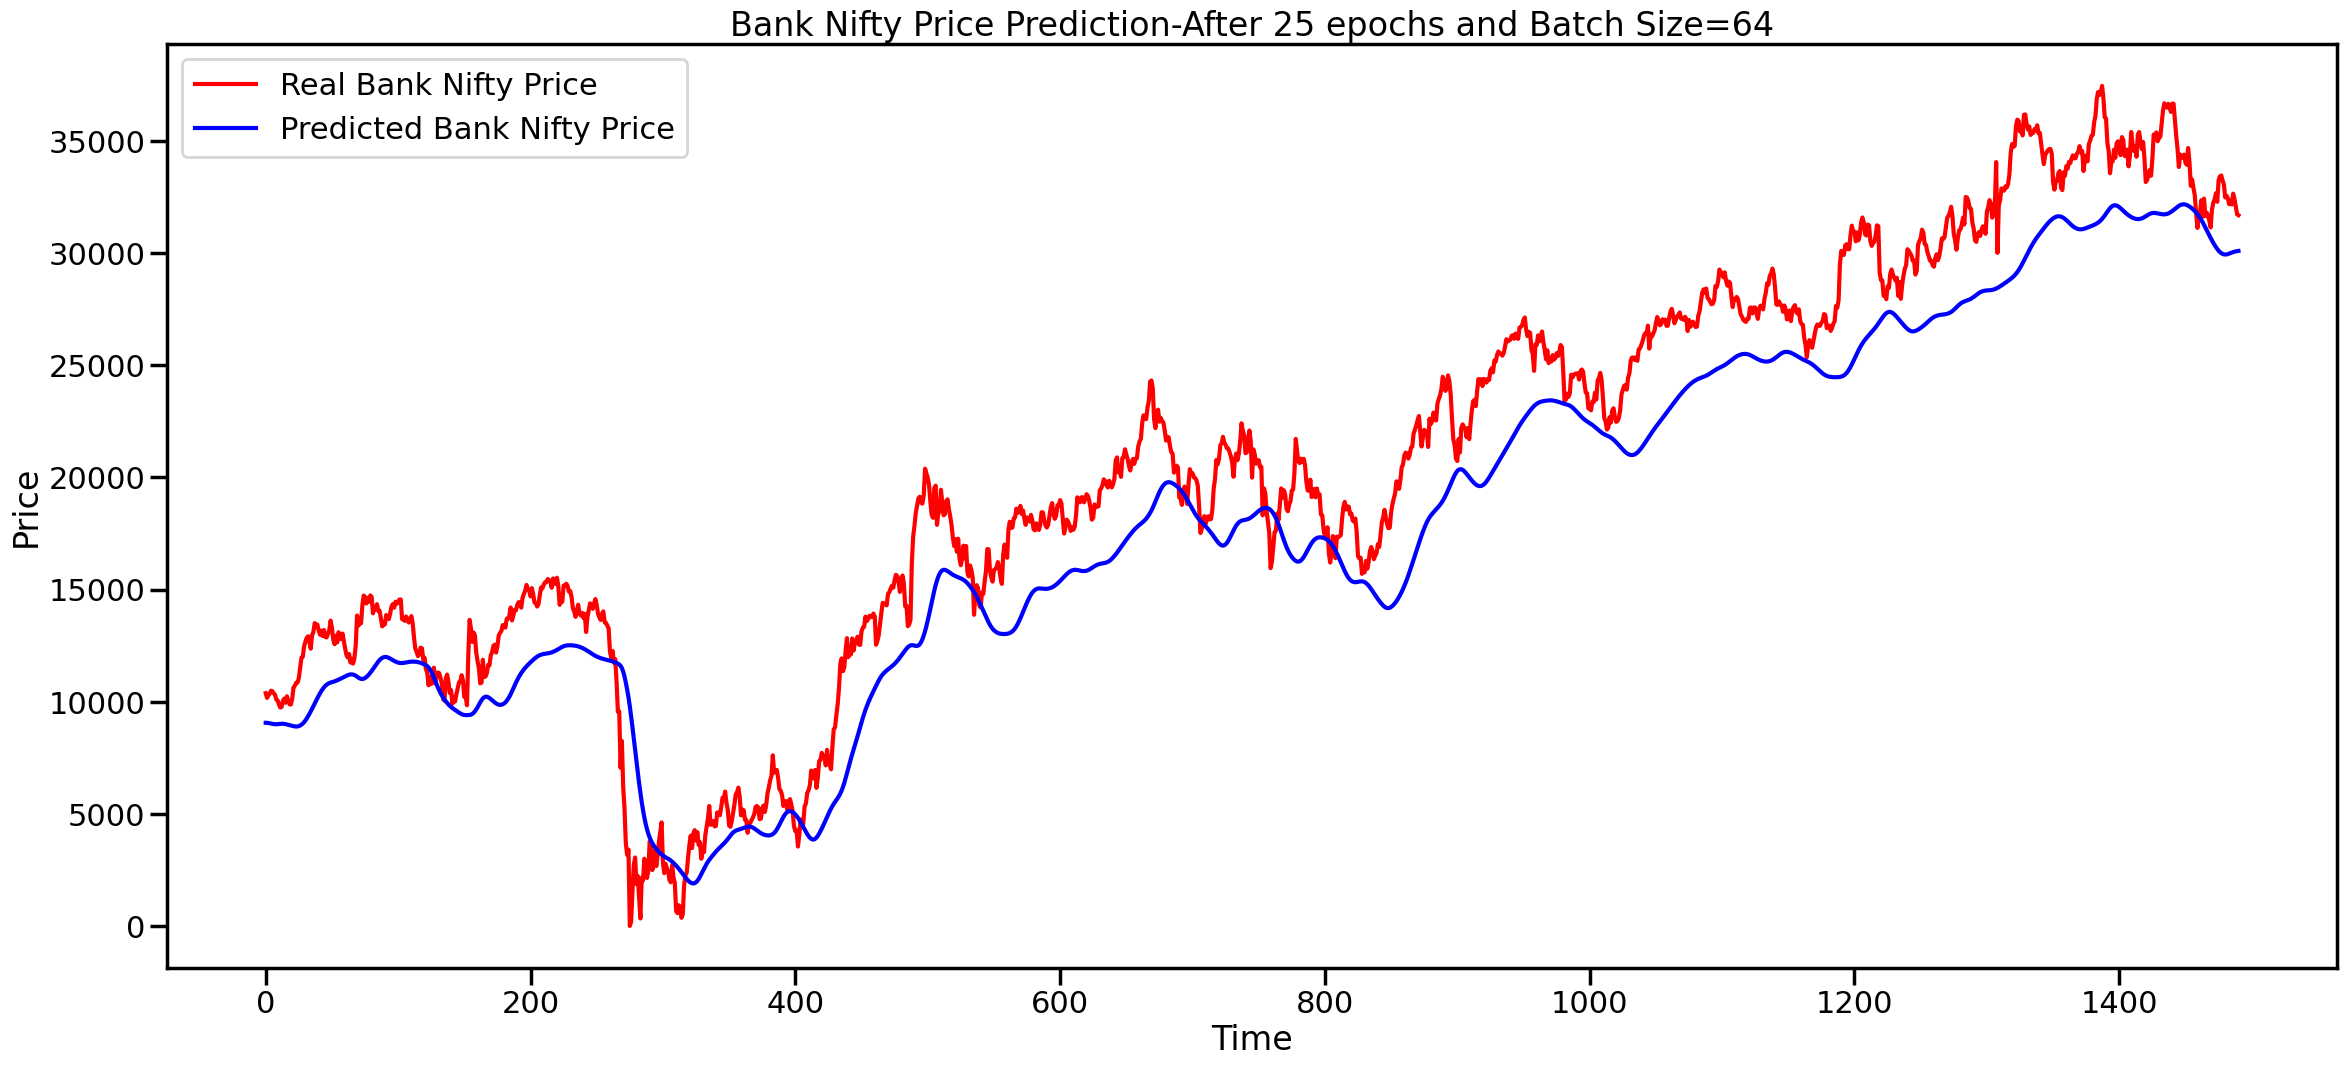

In [71]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 25 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

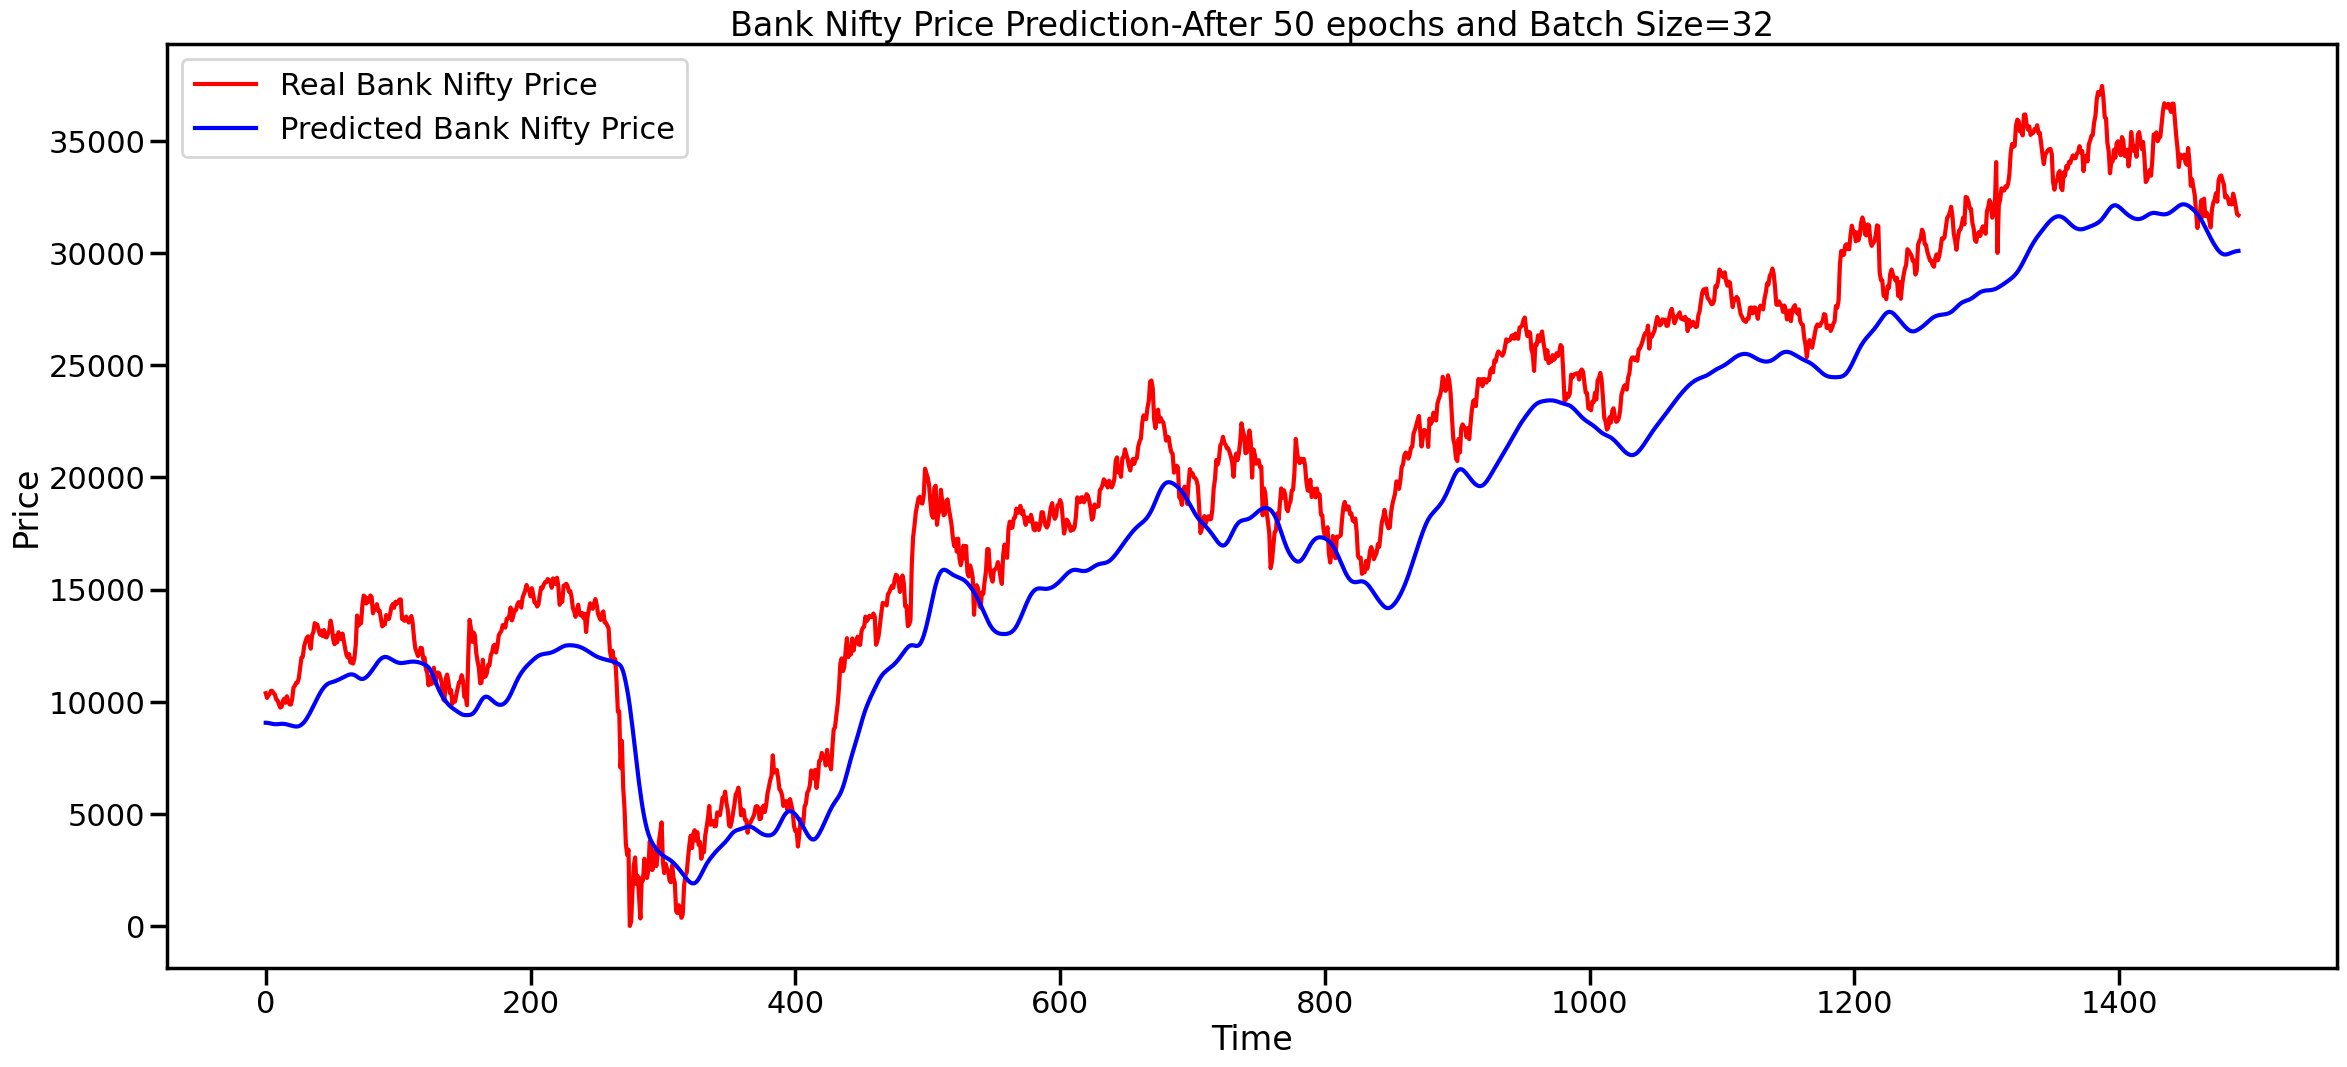

In [72]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 50 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()